**Modelo de red neuronal GRU**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo GRU
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [1]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input,GRU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [2]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [4]:
df=pd.read_csv('df_EDA.csv',
                parse_dates={'dt':['Date','time']},
                infer_datetime_format=True,
                low_memory=False,
                index_col='dt')

In [5]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'other_consumption'],
      dtype='object')

In [6]:
df=df[['Global_active_power','Global_intensity', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]

In [7]:
## resampling of data over hour
df = df.resample('D').mean()

In [8]:
#Setear semilla
np.random.seed(42)

#2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [9]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()
min_scaler=MinMaxScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

df.head()

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,2.034827,1.981839,-0.579222,-0.344607,-1.006100,-0.715621,-0.877707
2007-01-02,-0.479665,-0.505030,0.254588,0.541014,-1.006100,-0.717544,-0.698740
2007-01-03,-0.913282,-0.919220,0.380838,1.328309,-1.006100,-0.719467,-1.170300
2007-01-04,2.902136,2.905632,0.491035,-0.529403,-0.344237,2.768191,0.438568
2007-01-05,1.974266,1.963020,-0.085215,-0.165616,-0.072187,-0.702637,-0.425828


In [10]:
print("Normalizacion realizada")

Normalizacion realizada


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [11]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [12]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [13]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [14]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [15]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [16]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


#5.GRU

In [17]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [18]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

In [25]:
# Función para crear el modelo GRU
def create_model(neurons, dropout,layers,learning_rate,activacion):

    #Creacion de la arquitectura GRU
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(GRU(units=neurons, return_sequences=(layers-1), activation=activacion, input_dim=X_train.shape[2]))
        model.add(Dropout(dropout))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [21]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']
    activacion = params['activacion']

    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)
    print(f"{neurons},{layers},{batch_size}")
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de GRU
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate),activacion)

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [22]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 100, 800, 20),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.0005),
}

In [26]:
print("Se inicia entrenamiento...")
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)
print("Modelo entrenado!")

Se inicia entrenamiento...
780.0,2.0,80.0
800.0,1.0,90.0
100%|██████████| 2/2 [02:50<00:00, 85.21s/trial, best loss: 49.754787578582764]
Modelo entrenado!


In [27]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores_test']

In [28]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [29]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'activacion': 'relu',
 'batch_size': 90.0,
 'dropout': 0.5892501909076527,
 'epochs': 800,
 'layers': 1.0,
 'learning_rate': 0.00011592590876799372,
 'neurons': 800.0,
 'optimizer': 'adam'}

# 6.Evaluacion del modelo

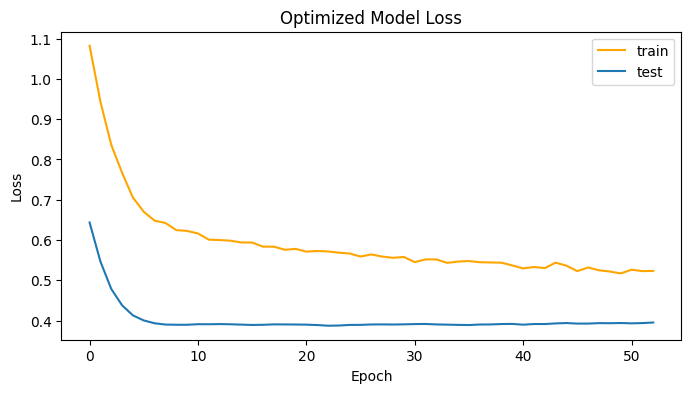

In [30]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [31]:
#Se realiza prediccion
results = best_model.predict(X_test)

results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

9/9 [==============================] - 0s 4ms/step


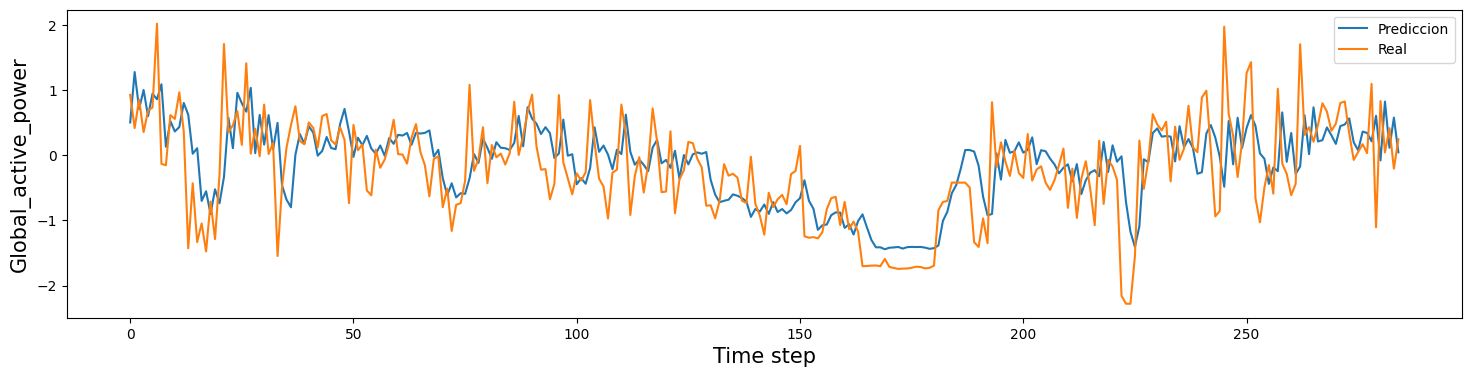

In [32]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [33]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.39010944962501526
RMSE: 0.6245874166488647
MAE: 0.46400490403175354
MAPE: 236.82286071777344


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "GRU_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [ ]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [ ]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

In [ ]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_GRU_CE.csv')

In [ ]:
results_csv.shape

Se guarda cada modelo keras en un objeto Json

In [ ]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_GRU'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [ ]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "GRU_CE"+"_"+str(trial)+"_"+str(k) + "__"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    nameModel_j=nameModel+"."+"json"
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1